# 16-6. 프로젝트 - Movielens 영화 SBR
이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


```
1) 데이터 확인
$ ls -l ~/data

2) 프로젝트 폴더 생성
$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결
$ ln -s ~/data/* ~/aiffel/yoochoose/data
```

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터 설명(README)를 읽어 봅니다. 

f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
# 유저수와 아이템수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
#UserId_ 각 세션이 몇개의 클릭 데이터를 갖는지
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
userid_length.median(), userid_length.mean()

(96.0, 165.5975165562914)

In [8]:
userid_length.min(), userid_length.max()

(20, 2314)

In [9]:
userid_length.quantile(0.999)

1343.181000000005

userid (item수 3706)
- 최소값:20, 최대값:2314
- 중간값:96, 평균값:165
- 99.9%값은 1343이하의 값

In [10]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [12]:
long_userid = userid_length[userid_length==2314].index[0]
data[data['UserId']==long_userid]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


단지 영화를 좋아하는 사람으로 알았지만
4169유저의 기록을 보면 동시간대에 여러번 평점을 매긴것으로 보아 옳지않은 유저정보로 보인다.(이상치)

In [13]:
length_count = userid_length.groupby(userid_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

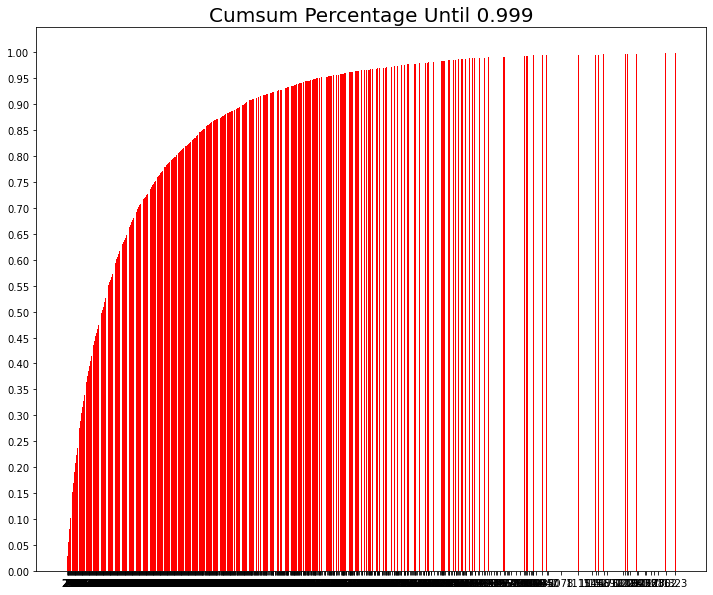

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [15]:
drop_index = userid_length[userid_length>1000].index #한 유저당 너무 많은 기록(1000이상)은 삭제할 것
data.drop(index=drop_index, inplace=True)

데이터셋은 대략 3년간의 영화평점


In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [17]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습다. 
- 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용

In [18]:
year_ago = latest - dt.timedelta(180)     # 최종 날짜로부터 365일 이전 날짜를 구한다.  
data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 08:05:50
5256,36,1701,4,2002-12-22 08:05:50
5184,36,2694,3,2002-12-22 08:08:14
5364,36,3786,4,2002-12-22 08:08:41
5262,36,2369,4,2002-12-22 08:09:24
...,...,...,...,...
984733,5950,1262,4,2003-02-27 18:17:38
986778,5956,469,3,2002-09-30 03:54:57
992702,5996,168,3,2002-09-03 13:12:26
992459,5996,339,4,2002-10-07 13:24:39


추천시스템은 *트렌드에 민감*<br>
- 사용자들의 소비패턴이 자주 달라진다.
- 그래서 마지막 기준에서 1년전까지의 평가 데이터만 구함
- 

모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다. 대회에서 Test Set을 제공해 주고 있습니다. 한 번 살펴봅시다.


추천 시스템은 지금 잘 예측하는 게 중요합니다. 1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 사용자들의 소비 패턴이 달라지기 때문입니다. 이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.

이번 자료에서는 가장 마지막 1일 기간 동안을 Test로, 2일 전부터 1일 전 까지를 valid set으로 나누겠습니다.

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()    
    userid_in_train = data.loc[data['Time'] < final_time - dt.timedelta(n_days)]
    userid_in_test = data.loc[data['Time'] >= final_time - dt.timedelta(n_days)]
    return userid_in_train, userid_in_test

In [20]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 2302
	 Users: 181
	 Items: 1306
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2002-10-31 16:33:08

* valid Set Stats Info
	 Events: 3137
	 Users: 197
	 Items: 1509
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2002-12-30 16:54:04

* test Set Stats Info
	 Events: 3384
	 Users: 182
	 Items: 1608
	 First Time : 2002-12-30 18:21:02
	 Last Time : 2003-02-28 17:49:50



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
#데이터 저장 다음, data pipeline을 구축하는 단계로 넘어갈 것
save_path = data_path / 'processed_mov'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [25]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [26]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
9676,65,2194,5,2002-09-29 21:33:17,0
21700,157,3753,4,2002-10-11 16:42:02,1
21434,157,912,5,2002-10-11 16:53:02,2
21533,157,3196,5,2002-10-11 16:53:02,3
21604,157,1944,4,2002-10-11 16:53:02,4
21670,157,527,5,2002-10-11 16:53:02,5
21681,157,1204,4,2002-10-11 16:53:02,6
21686,157,1208,4,2002-10-11 16:53:02,7
21369,157,1263,4,2002-10-11 16:53:43,8
21421,157,1299,4,2002-10-11 16:53:43,9


In [27]:
tr_dataset.click_offsets

array([   0,    1,   26,   27,   92,  111,  112,  114,  146,  151,  152,
        201,  210,  213,  215,  223,  224,  225,  255,  263,  264,  265,
        267,  280,  283,  305,  316,  322,  324,  431,  438,  451,  464,
        474,  479,  483,  487,  490,  497,  502,  506,  508,  545,  547,
        559,  575,  577,  580,  581,  593,  594,  598,  606,  607,  608,
        611,  612,  620,  626,  632,  640,  659,  664,  668,  674,  678,
        682,  693,  698,  719,  725,  726,  727,  733,  734,  781,  817,
        819,  822,  830,  832,  833,  835,  839,  871,  874,  892,  893,
        895,  936, 1026, 1044, 1052, 1055, 1099, 1101, 1102, 1103, 1107,
       1108, 1109, 1170, 1175, 1176, 1180, 1183, 1184, 1188, 1189, 1194,
       1242, 1303, 1310, 1324, 1329, 1330, 1348, 1349, 1351, 1360, 1361,
       1363, 1368, 1386, 1417, 1419, 1423, 1424, 1430, 1431, 1435, 1438,
       1439, 1454, 1468, 1643, 1645, 1654, 1661, 1662, 1669, 1685, 1885,
       1903, 1904, 1911, 1915, 1919, 1922, 1923, 19

In [28]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

4.2 SessionDataLoader
파이썬 문법 중 iterator, generator에 대한 좀 더 친절한 안내가 필요하신 분은 이 [자료](https://dojang.io/mod/page/view.php?id=2405)를 먼저 보시길 권장합니다.

```SessionDataset``` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
```__iter__``` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 ```yield```합니다.
mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
9676,65,2194,5,2002-09-29 21:33:17,0
21700,157,3753,4,2002-10-11 16:42:02,1
21434,157,912,5,2002-10-11 16:53:02,2
21533,157,3196,5,2002-10-11 16:53:02,3
21604,157,1944,4,2002-10-11 16:53:02,4
21670,157,527,5,2002-10-11 16:53:02,5
21681,157,1204,4,2002-10-11 16:53:02,6
21686,157,1208,4,2002-10-11 16:53:02,7
21369,157,1263,4,2002-10-11 16:53:43,8
21421,157,1299,4,2002-10-11 16:53:43,9


In [31]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다. input, output, mask의 감을 잡아 봅시다.

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 90   1 110  26]
Label Item Idx are :       [ 91   2 111  27]
Previous Masked Input Idx are [2]


## Step 3. 모델 구성

### Evaluation Metric

모델 성능 평가를 위한 지표를 보겠습니다.<br>
- 모델 성능에 대한 지표로 precision이나 recall이 있습니다.
- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋은 것
- recall의 개념을 확장한 지표인 ```recall@k```
- 순서에 민감한 지표인 ```MRR```
- ```MRR```은 정답 아이템이 나온 순번의 역수 값이다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것이다.

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [36]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [37]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 1306)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      203700    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 1306)                66606     
Total params: 270,306
Trainable params: 270,306
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.73it/s]


	 - Recall@20 epoch 1: 0.023575
	 - MRR@20    epoch 1: 0.005481



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.84it/s]


	 - Recall@20 epoch 2: 0.031250
	 - MRR@20    epoch 2: 0.006566



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.80it/s]


	 - Recall@20 epoch 3: 0.029605
	 - MRR@20    epoch 3: 0.006488



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.83it/s]


	 - Recall@20 epoch 4: 0.027412
	 - MRR@20    epoch 4: 0.004729



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.90it/s]


	 - Recall@20 epoch 5: 0.026864
	 - MRR@20    epoch 5: 0.004683



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.86it/s]


	 - Recall@20 epoch 6: 0.026864
	 - MRR@20    epoch 6: 0.004175



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.84it/s]


	 - Recall@20 epoch 7: 0.025219
	 - MRR@20    epoch 7: 0.004202



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.82it/s]


	 - Recall@20 epoch 8: 0.026864
	 - MRR@20    epoch 8: 0.004316



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.83it/s]


	 - Recall@20 epoch 9: 0.027412
	 - MRR@20    epoch 9: 0.004315



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.89it/s]

	 - Recall@20 epoch 10: 0.027961
	 - MRR@20    epoch 10: 0.004387



## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  42%|████▏     | 42/100 [00:07<00:09,  5.90it/s]

	 - Recall@20: 0.020833
	 - MRR@20: 0.005319



### 시도2

In [41]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 1306)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      203700    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 1306)                66606     
Total params: 270,306
Trainable params: 270,306
Non-trainable params: 0
_________________________________________________________________


In [42]:
train_model(model, args)

Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.85it/s]


	 - Recall@20 epoch 1: 0.027412
	 - MRR@20    epoch 1: 0.008068



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.96it/s]


	 - Recall@20 epoch 2: 0.035088
	 - MRR@20    epoch 2: 0.007537



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.95it/s]


	 - Recall@20 epoch 3: 0.032346
	 - MRR@20    epoch 3: 0.006288



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.93it/s]


	 - Recall@20 epoch 4: 0.030154
	 - MRR@20    epoch 4: 0.003962



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.88it/s]


	 - Recall@20 epoch 5: 0.028509
	 - MRR@20    epoch 5: 0.003698



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.93it/s]


	 - Recall@20 epoch 6: 0.027412
	 - MRR@20    epoch 6: 0.003681



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.91it/s]


	 - Recall@20 epoch 7: 0.027412
	 - MRR@20    epoch 7: 0.003617



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.97it/s]


	 - Recall@20 epoch 8: 0.028509
	 - MRR@20    epoch 8: 0.003572



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  6.03it/s]


	 - Recall@20 epoch 9: 0.027961
	 - MRR@20    epoch 9: 0.003721



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.89it/s]

	 - Recall@20 epoch 10: 0.029057
	 - MRR@20    epoch 10: 0.003872



In [43]:
test_model(model, args, test)

Evaluation:  42%|████▏     | 42/100 [00:07<00:09,  5.92it/s]

	 - Recall@20: 0.019345
	 - MRR@20: 0.005044



### 시도3

In [44]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.3, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 1306)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      203700    
_________________________________________________________________
dropout_2 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 1306)                66606     
Total params: 270,306
Trainable params: 270,306
Non-trainable params: 0
_________________________________________________________________


In [45]:
train_model(model, args)

Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.90it/s]


	 - Recall@20 epoch 1: 0.027412
	 - MRR@20    epoch 1: 0.004527



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.99it/s]


	 - Recall@20 epoch 2: 0.033443
	 - MRR@20    epoch 2: 0.005661



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.99it/s]


	 - Recall@20 epoch 3: 0.030702
	 - MRR@20    epoch 3: 0.007143



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.88it/s]


	 - Recall@20 epoch 4: 0.025768
	 - MRR@20    epoch 4: 0.003506



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.96it/s]


	 - Recall@20 epoch 5: 0.026316
	 - MRR@20    epoch 5: 0.003546



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.96it/s]


	 - Recall@20 epoch 6: 0.026316
	 - MRR@20    epoch 6: 0.003577



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.80it/s]


	 - Recall@20 epoch 7: 0.026316
	 - MRR@20    epoch 7: 0.003567



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.93it/s]


	 - Recall@20 epoch 8: 0.026316
	 - MRR@20    epoch 8: 0.003546



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.95it/s]


	 - Recall@20 epoch 9: 0.027412
	 - MRR@20    epoch 9: 0.003606



Evaluation:  63%|██████▎   | 57/91 [00:09<00:05,  5.93it/s]

	 - Recall@20 epoch 10: 0.026864
	 - MRR@20    epoch 10: 0.003572



In [46]:
test_model(model, args, test)

Evaluation:  42%|████▏     | 42/100 [00:07<00:09,  5.86it/s]

	 - Recall@20: 0.019345
	 - MRR@20: 0.004470



# 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항||상세기준|
|:------||:-------|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.||데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.||적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.||3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

# 회고

1) drop rate: 0.1<br>
Evaluation:  42%|████▏     | 42/100 [00:07<00:09,  5.90it/s]
	 - Recall@20: 0.020833
	 - MRR@20: 0.005319
        
        
2) drop rate: 0.2<br>
Evaluation:  42%|████▏     | 42/100 [00:07<00:09,  5.90it/s]
	 - Recall@20: 0.020833
	 - MRR@20: 0.005319
        
        
3) drop rate: 0.3<br>
Evaluation:  42%|████▏     | 42/100 [00:07<00:09,  5.86it/s]
	 - Recall@20: 0.019345
	 - MRR@20: 0.004470

- drop rate만 조정해서 총 3번 모델을 시도해봤다.
- drop rate만 바꿔서 큰 변화는 없었다. 데이터 전처리 부분에서 중요하다고 생각했다.

이번에 딱히 시도를 한 건 많이 없었지만 자꾸 에러가 떠서, 에러가 뜰때마다 우수노드 참고를 많이 했었다.
(이게 왜 안될까,,, 이게 왜 되는거지???했던 의문이)
코딩의 세계는 알면서도 모르는 것일까

길이분석에서는<br> 약 3년간의 데이터셋에서 20부터 2000까지 다양한 유저의 영화선호도(rating)가 있었다.
동시간대에 영화 평점을 여러개 매긴 유저가 있었는데 그 유저의 행동은 평점테러라던가 다른 사람에게 옳지 않은 추천으로 작용할 영향이 있을거라고 판단하여 제외했다.
어느부분이상을 제외해야하는가에 고민을 했었다. 정말 영화를 좋아하고 일일히 평점을 매기는 유저일 수도 있을 것같단 생각도 했었다.

시간분석에서는<br> 추천시스템은 트렌드의 영향을 많이 받기 때문에 사용자들의 선호패턴을 잘 파악해야한다.
영화도 트렌드라고 할만한 사용자의 선호도가 있을까? 영화는 신작에 반영을 많이 받아서 만약 마블 영화가 개봉했을 경우 이전의 마블 영화들을 사람들이 다시 찾아 보는 등 하는건 있을 것같다.
하지만 시각적으로 전혀 볼 수 없어서 시각적으로도 같이 보는 방법이 모델 판단에 더 좋겠다.
모델이 평가하면 평가하는대로 보는게 의문점이 든다. 제대로 나오는게 맞는건지

+)2개월단위로 했지만 나중에 6개월, 9개월 단위로 다시 해봐도 좋을 것 같다.